In [1]:
import os
import argparse
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader

In [2]:
#from PlotSpinalCordDatafile_withSlidingWindow import test as sodiumInterpVals
#from PlotSpinalCordDatafile_withSlidingWindow import interpTimes, times
#from PlotSpinalCordDatafile_withSlidingWindow import dataArr as uninterp
from PlotSpinalCordDatafile_withSlidingWindow import slidingData 
from PlotSpinalCordDatafile_withSlidingWindow import times, dataArr

BUN , BUN/Creatinine Ratio
0.8774417368026577
BUN/Creatinine Ratio , BUN
0.8774417368026577


In [3]:
method = 'dopri5'   #
learning_rate = 1e-3
data_size = 34
train_len = int(data_size * 0.7)
test_len = int((data_size - train_len) / 2)
valid_len = data_size - train_len - test_len
batch_size = 16
batch_time = 2
niters = 750 # epoch/ number of iteration steps
input_dim = 2
output_dim = 1
hidden_dim = 25
gpu = 0
adjoint = False

In [4]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [5]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [6]:
print(device)

cpu


In [7]:
print(dataArr[0])
print(times)

[141. 140. 138. 139. 138. 141. 139. 141. 142. 139. 142. 139. 142. 142.
 140. 139. 139. 141. 137. 141. 140. 141. 144. 145. 147. 143.]
[1217737. 1016080.  874834.  834544.  774086.  733753.  693271.  632994.
  566848.  473272.  432863.  392559.  372264.  352148.  321956.  301766.
  271567.  239827.  170814.  130406.   98711.   71492.    7721.    6179.
    5585.       0.]


In [8]:
def moving_average(data):
    noStr = data #define noStr to be the sodium 
    window_size = 3
    moving_averages = [] #array to keep the new "long wave" values
    length = len(noStr)
    ##Checking to see if the variables are defined properly
    #print(len(noStr))
    #print(len(np.flip(times)))

    # Loop through the array t o
    #consider every window of size 3
    i = 0
    while  i < len(noStr)-window_size+1:

        # Calculate the average of current window
        window_average = round(np.sum(noStr[i:i+window_size]) / window_size, 2)

        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1
    moving_averages.append(noStr[length-2]) # First assign f(t_24) from no
    moving_averages.append(noStr[length-1])
    moving_averages[length-2] = round((moving_averages[length-3]+moving_averages[length-1])/2,2)
    #print(noStr[23:26]) # pulling from the orginal data to identify the 2 values we need to solve for < t_n -> t_n-2 >   
    #moving_averages.append(noStr[24]) # First assign f(t_24) from no
    #moving_averages.append(noStr[25])
    #moving_averages[24] = round((moving_averages[23]+moving_averages[25])/2,2)
    return(np.asarray(moving_averages))

In [9]:
# This function adds data points between indices 23 and 25
def interpData(data):
    data = np.flip(data)
    new_length = 11 
    interp= np.linspace(data[23], data[25], new_length)
    newData = np.delete(data, (23,24,25))
    newData = np.append(newData, interp)
    return (np.asarray(newData))

In [10]:
#times = (np.flip(newTime))/24/60
#print(times)

In [11]:
interpTimes = interpData(times)
print(len(interpTimes))

34


In [12]:
dataInterp = interpData(dataArr[0])
print(dataInterp)

[143.  147.  145.  144.  141.  140.  141.  137.  141.  139.  139.  140.
 142.  142.  139.  142.  139.  142.  141.  139.  141.  138.  139.  138.
 138.3 138.6 138.9 139.2 139.5 139.8 140.1 140.4 140.7 141. ]


In [13]:
window_avgs = moving_average(dataInterp)
print(window_avgs)

[145.   145.33 143.33 141.67 140.67 139.33 139.67 139.   139.67 139.33
 140.33 141.33 141.   141.   140.   141.   140.67 140.67 140.33 139.33
 139.33 138.33 138.43 138.3  138.6  138.9  139.2  139.5  139.8  140.1
 140.4  140.7  140.85 141.  ]


In [14]:
scale = StandardScaler(copy=True, with_mean=True, with_std=True)
scaled = scale.fit_transform(window_avgs.reshape(-1, 1).astype('float32'))

In [15]:
true_y = torch.tensor(scaled.copy().astype('float32')).to(device)
# true_y = torch.tensor(window_avgs.copy().astype('float32')).reshape((-1,1)).to(device)
t = torch.tensor((interpTimes/24/60).copy()).to(device)
print(t)
best_loss = 1000000000

tensor([  0.0000,   3.8785,   4.2910,   5.3618,  49.6472,  68.5493,  90.5597,
        118.6208, 166.5465, 188.5882, 209.5597, 223.5806, 244.5472, 258.5167,
        272.6104, 300.5993, 328.6611, 393.6444, 439.5792, 481.4382, 509.5507,
        537.5597, 579.5444, 607.5236, 631.3363, 655.1490, 678.9617, 702.7744,
        726.5872, 750.3999, 774.2126, 798.0253, 821.8380, 845.6507],
       dtype=torch.float64)


In [16]:
def create_dataset(dataset, time_set, batch_time, len):
    dataY0, dataY, time_T = [], [], []
    for i in range(len-batch_time):
        dataY0.append(dataset[i])   # initial values for ODE
        dataY.append(dataset[i:(i + batch_time)])  # predict batch_time steps/label ahead from initial
        time_T.append(time_set[i:(i + batch_time)])  # specify time points to predict
    return dataY0, dataY, time_T

In [17]:
train_Y0, train_Y, train_time_T = create_dataset(dataset=true_y[:train_len], time_set=t[:train_len],
                                                 batch_time=batch_time, len=train_len)
train_Y0 = torch.stack(train_Y0)  # (M, 1, D)=(997, 1, 2)  # convert a list of tensor to a tensor
train_Y = torch.stack(train_Y)    # (M, T, 1, D)=(997, 3, 1,2)  # convert  a list of tensor to a tensor
# train_Y = train_Y.permute(1, 0, 2, 3)  # convert shape of Y to be (T, M, 1, D)=(3, 997, 1,2)
train_time_T = torch.stack(train_time_T)  # (M, T)
print(train_Y0.shape)
print(train_Y.shape)
print(train_time_T.shape)

torch.Size([21, 1])
torch.Size([21, 2, 1])
torch.Size([21, 2])


In [18]:
test_Y0, test_Y, test_time_T = create_dataset(dataset=true_y[train_len:(train_len+test_len)], time_set=t[train_len:(train_len+test_len)],
                                              batch_time=batch_time, len=test_len)
test_Y0 = torch.stack(test_Y0)
test_Y = torch.stack(test_Y)
# test_Y = test_Y.permute(1, 0, 2, 3)
test_time_T = torch.stack(test_time_T)

In [19]:
valid_Y0, valid_Y, valid_time_T = create_dataset(dataset=true_y[(train_len+test_len):], time_set=t[(train_len+test_len):],
                                              batch_time=batch_time, len=valid_len)
valid_Y0 = torch.stack(valid_Y0)
valid_Y = torch.stack(valid_Y)
# test_Y = test_Y.permute(1, 0, 2, 3)
valid_time_T = torch.stack(valid_time_T)

In [20]:
# ------------ Put data and labels together via TensorDataset ------------- #
train_dataset = TensorDataset(train_Y0, train_Y, train_time_T)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_Y0, test_Y, test_time_T)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [21]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [22]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            #add more layers rather than more nodes
            nn.Linear(input_dim, hidden_dim*4),
            nn.Tanh(),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.Tanh(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        y = torch.squeeze(y)
        y_new = torch.hstack((t, y))
        y_new = y_new[None, None, :]
        #print(f'new y is: {y_new}, {y_new.shape}')
        return self.net(y_new)

In [23]:
ii = 0  #
func = ODEFunc().to(device)  # RHS of ODE system parameterized by FNN
optimizer = optim.Adam(func.parameters(), lr=learning_rate)
start = time.time()
best_loss = 10000000
train_loss_vector = []   # batch loss on training set
test_loss_vector = []    # total loss on test set
best_iter = 0

start_time = time.time()

for itr in range(1, niters + 1):  # iteration starts from 1
    test_loss = 0.0
    train_loss = 0.0
    for batch_idx, (y0_train, y_train, t_train) in enumerate(train_loader):  # mini-batch
        batch_loss = 0.0
        for i in range(len(t_train)):  # feed the samples from mini-batch to odeint one by one
            # print(f'------ batch idx {batch_idx}, i is: {i}, len of t is: {len(t_train)}')
            y_train1 = y_train[i]  # pick one sample with shape (T, 1, D)
            y_train1 = y_train1[:, None, None, :]  # convert shape of y from (T, 1, D) to ideal shape (T, 1, 1, D)
            y0_train1 = y0_train[i]  # pick one initial value with shape (1, D)
            y0_train1 = y0_train1[None, :]  # convert shape of y0 from (1, D) to ideal shape (1, 1, D)
            pred_y = odeint(func, y0_train1, t_train[i]).to(device)  # shape of t_train is (batch_time, )
            loss = torch.mean(torch.abs(pred_y - y_train1))
            batch_loss += loss
        optimizer.zero_grad()   # zero all your gradient before you do the backpro.
        batch_loss.backward()   # backpro to compute the gradient
        optimizer.step()  # update the parameters theta=(W,b) using the gradient obtained using loss.backward()
        train_loss += batch_loss.item()  # count training loss for all training data points
        train_loss_vector.append(train_loss)
    with torch.no_grad():
        for batch_idx1, (y0_test, y_test, t_test) in enumerate(test_loader):  # mini-batch
            batch_loss1 = 0.0
            for i in range(len(t_test)):  # feed samples from mini-batch to odeint one by one
                y_test1 = y_test[i]  # pick one element with shape (T, 1, D)
                y_test1 = y_test1[:, None, None, :]  # convert the shape from (T, 1, D) to (T, 1, 1, D)
                y0_test1 = y0_test[i]  # pick one initial with shape (1, D)
                y0_test1 = y0_test1[None, :]   # convert the shape to (1, 1, D)
                pred_y1 = odeint(func, y0_test1, t_test[i])
                loss1 = torch.mean(torch.abs(pred_y1 - y_test1))
                batch_loss1 += loss1.item()
            test_loss += batch_loss1
            test_loss_vector.append(test_loss)
        if test_loss < best_loss:
            best_loss = test_loss
            best_iter = itr
            save_path = f'/Users/dezmon/CSCE587/REU/REU-NODE-main/best_model_{batch_time}_{niters}_{start_time}.pth'
            torch.save(func.state_dict(), save_path)  # saving the model
            
end = time.time()
print(f'training time is {end-start}')
_bt = batch_time
_bs = batch_size
while(os.path.exists(f'/Users/dezmon/CSCE587/REU/REU-NODE-main/training loss_{_bt}_{_bs}.txt')):
    _bt += 1
    _bs += 1
np.savetxt(f'/Users/dezmon/CSCE587/REU/REU-NODE-main/training loss_{_bt}_{_bs}.txt', train_loss_vector, delimiter='\n')
np.savetxt(f'/Users/dezmon/CSCE587/REU/REU-NODE-main/val loss_{_bt}_{_bs}.txt', test_loss_vector, delimiter='\n')

training time is 426.8665382862091


Best Loss: 0.2813877463340759
Relative Error: -1.006659984588623


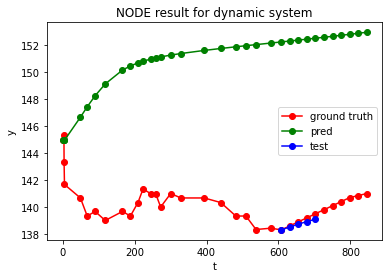

In [25]:
true_y0 = true_y[0]
func.load_state_dict(
    torch.load(f'/Users/dezmon/CSCE587/REU/REU-NODE-main/best_model_{batch_time}_{niters}_{start_time}.pth', map_location=lambda storage, loc: storage))
whole_pred = odeint(func, true_y0, t)
whole_pred = whole_pred.detach().cpu()
test_pred = odeint(func, true_y[23], t[23:28])
test_pred = test_pred.detach().cpu()
#valid_pred = odeint(func, true_y[23], t[23:28])
#valid_pred = valid_pred.detach().cpu()
relative_error = torch.sum(torch.abs(true_y[23].cpu() - test_pred) / true_y[23].cpu())
print(f'Best Loss: {best_loss}')
print(f'Relative Error: {relative_error}')
plt.plot(t.cpu(), scale.inverse_transform(true_y.cpu()), '-ro')
plt.plot(t.cpu(), scale.inverse_transform(whole_pred),'-go')
# plt.plot(t[20:23].cpu(), scale.inverse_transform(test_pred))
plt.plot(t[23:28].cpu(), scale.inverse_transform(test_pred), '-bo')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['ground truth', 'pred', 'test'])
plt.title('NODE result for dynamic system')
plt.show()

Best Loss: 0.2813877463340759
Relative Error: 5.701632976531982


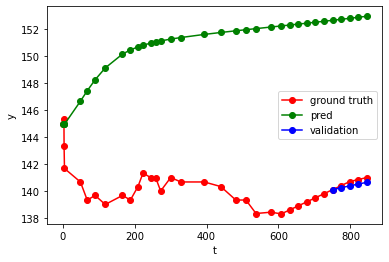

In [26]:
true_y0 = true_y[0]
whole_pred = odeint(func, true_y0, t)
whole_pred = whole_pred.detach().cpu()
valid_pred = odeint(func, true_y[29], t[29:])
valid_pred = valid_pred.detach().cpu()
relative_error = torch.sum(torch.abs(true_y[29:].cpu() - valid_pred) / true_y[29:].cpu())
print(f'Best Loss: {best_loss}')
print(f'Relative Error: {relative_error}')
plt.plot(t.cpu(), scale.inverse_transform(true_y.cpu()),'-ro')
plt.plot(t.cpu(), scale.inverse_transform(whole_pred),'-go')
plt.plot(t[29:].cpu(), scale.inverse_transform(valid_pred),'-bo')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['ground truth', 'pred', 'validation'])
#plt.title('NODE result for dynamic system dy/dt=Ay^3')
plt.show()

In [ ]:
min(train_loss_vector)

In [ ]:
print(pred_y)
print(y_test1)